In [48]:
from tensorflow.keras.models import Model

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import sys

In [7]:
import random
from PIL import Image
import glob
import time
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
import cv2

In [11]:
import pandas as pd

In [12]:
from matplotlib.pyplot import figure

In [22]:
def load_rgb_data(img_dir, img_size, shuffle=True):
    print("Loading images...")
    data = []
    directories = next(os.walk(img_dir))[1]
    for directory_name in directories:
        print("loading {0}".format(directory_name))
        file_names = next(os.walk(os.path.join(img_dir, directory_name)))[2]
        print("we will load [", len(file_names), "] files from [", directory_name, "] class ... ")
        for i in range(len(file_names)):
            image_name = file_names[i]
            image_path = os.path.join(img_dir, directory_name, image_name)
            label = directory_name
            img = Image.open(image_path)
            rgbimg = Image.new("RGB", img.size)
            rgbimg.paste(img)
            img=rgbimg
            
            img = img.resize((img_size, img_size), Image.ANTIALIAS)
            data.append([np.array(img), label])
            
    if shuffle:
        random.shuffle(data)
        
    training_images = np.array([i[0] for i in data], dtype='uint8').reshape(-1, img_size, img_size, 3)
    training_labels = np.array([i[1] for i in data])
    
    print ("File loading completed.")
    
    return training_images, training_labels

In [14]:
def normalize_data(dataset):
    dataset = dataset/255.0
    return dataset

In [15]:
def display_image(trainX, trainY, index=0):
    plt.imshow(trainX[index])
    print("label = "+ str(np.squeeze(trainY[index])))
    print("image shape: ", trainX[index].shape)
    plt.show()

In [16]:
def display_dataset_shape(X, Y):
    print("Shape of images: ", X.shape)
    print("Shape of labels: ", Y.shape)

In [17]:
def plot_sample_from_dataset(images, labels, rows=5, columns=10, width=8, height=8):
    plt.figure(figsize=(width, height))
    for i in range(rows*columns):
        plt.subplot(rows, columns, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(labels[i])
    plt.show()

In [18]:
def display_dataset_folders(path):
    classes = os.listdir(path)
    classes.sort()
    return classes

In [34]:
def get_data_distribution(img_dir, output_file=None, plot_stats=True):
    print("Loading images...")
    stats = []
    directories = next(os.walk(img_dir))[1]
    for directory_name in directories:
        print("loading {0}".format(directory_name))
        image_file_names = next(os.walk(os.path.join(img_dir, directory_name)))[2]
        print("we will load [", len(image_file_names), "] files from [", directory_name, "] class ... ")
        for i in range(len(image_file_names)):
            image_name = image_file_names[i]
            image_path = os.path.join(img_dir, directory_name, image_name)
            label = directory_name
            
            img = Image.open(image_path)
            
            rgbimg = Image.new("RGB", img.size)
            rgbimg.paste(img)

            width, height = img.size
            
            size_kb = os.stat(image_path).st_size/1000
            
            stats.append([label, os.path.basename(image_name), width, height, size_kb])
           
            
    if output_file is not None:
        stats_dataframe = pd.DataFrame(stats, columns = ["class", "filename", "width", "height", "size_kb"])
        stats_dataframe.to_csv(output_file, index=False)
        print("stats are collected and saved in .", output_file)
    else:
        print("stats collected")
    

    
    return stats

## Loading dataset

In [20]:
dataset_path = '/Users/florinstefan/Downloads/chest_xray/'
train_path = '/Users/florinstefan/Downloads/chest_xray/train/'
test_path = '/Users/florinstefan/Downloads/chest_xray/test/'
val_path = '/Users/florinstefan/Downloads/chest_xray/val/'

In [23]:
train_data, train_label = load_rgb_data(train_path, 224, shuffle = True)

Loading images...
loading PNEUMONIA
we will load [ 3875 ] files from [ PNEUMONIA ] class ... 
loading NORMAL
we will load [ 1341 ] files from [ NORMAL ] class ... 
File loading completed.


In [24]:
val_data, val_label = load_rgb_data(val_path, 224, shuffle = True)
print(val_data.shape)
print(val_label.shape)

Loading images...
loading PNEUMONIA
we will load [ 8 ] files from [ PNEUMONIA ] class ... 
loading NORMAL
we will load [ 8 ] files from [ NORMAL ] class ... 
File loading completed.
(16, 224, 224, 3)
(16,)


In [25]:
test_data, test_label = load_rgb_data(test_path, 224, shuffle=True)
print(test_data.shape)
print(test_label.shape)

Loading images...
loading PNEUMONIA
we will load [ 390 ] files from [ PNEUMONIA ] class ... 
loading NORMAL
we will load [ 234 ] files from [ NORMAL ] class ... 
File loading completed.
(624, 224, 224, 3)
(624,)


## Visualizing dataset

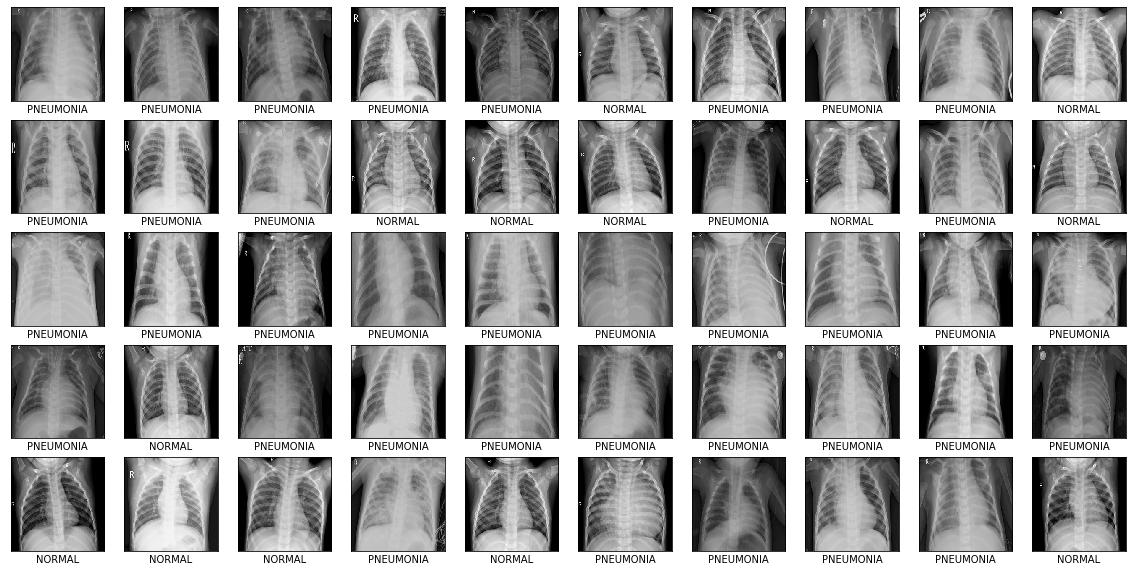

In [26]:
plot_sample_from_dataset(train_data, train_label, rows=5, columns=10, width=20, height=10)

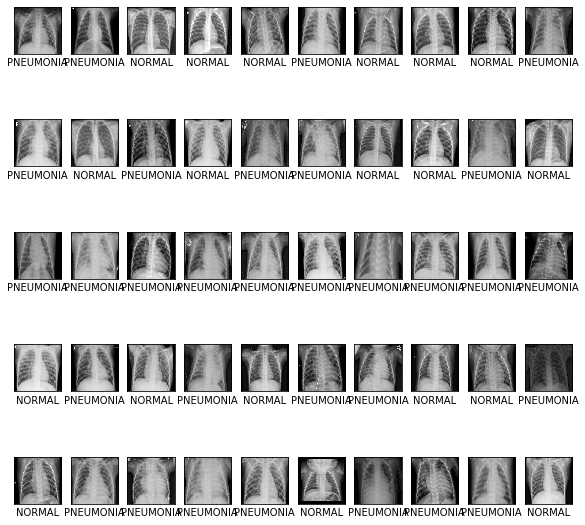

In [27]:
plot_sample_from_dataset(test_data, test_label, rows=5, columns=10, width=10, height=10)

label = PNEUMONIA
image shape:  (224, 224, 3)


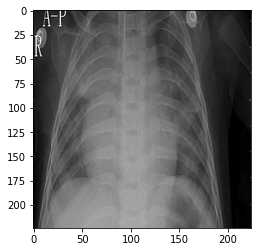

In [28]:
display_image(train_data, train_label, index=32)

In [30]:
display_dataset_shape(train_data, train_label)

Shape of images:  (5216, 224, 224, 3)
Shape of labels:  (5216,)


## Get .csv file for data visualizing data distribution

In [35]:
stats = get_data_distribution(train_path, output_file='/Users/florinstefan/Desktop/covid19_stats.csv')

Loading images...
loading PNEUMONIA
we will load [ 3875 ] files from [ PNEUMONIA ] class ... 
loading NORMAL
we will load [ 1341 ] files from [ NORMAL ] class ... 
stats are collected and saved in . /Users/florinstefan/Desktop/covid19_stats.csv


In [36]:
df = pd.read_csv('/Users/florinstefan/Desktop/covid19_stats.csv')
df.head()

,class,filename,width,height,size_kb
0,PNEUMONIA,person63_bacteria_306.jpeg,1048,736,57.793
1,PNEUMONIA,person1438_bacteria_3721.jpeg,984,672,60.298
2,PNEUMONIA,person755_bacteria_2659.jpeg,992,712,52.750
3,PNEUMONIA,person478_virus_975.jpeg,1224,888,95.265
4,PNEUMONIA,person661_bacteria_2553.jpeg,864,480,26.813


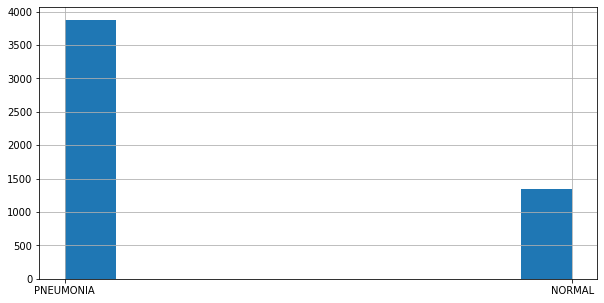

In [38]:
df['class'].hist(figsize=(10,5))

## Label binarizer & to_categorical and Normalizing data

In [39]:
train_data = normalize_data(train_data)

In [52]:
val_data = normalize_data(val_data)

In [40]:
print("Labels: ", train_label[:5])
lb = LabelBinarizer()
binary_labels = lb.fit_transform(train_label)
print("binary labels after binarizer: ", binary_labels[:5])
hot_encoded_labels = to_categorical(binary_labels)
print("Hot encoded labels after one hot encoding", hot_encoded_labels[:5])

Labels:  ['PNEUMONIA' 'PNEUMONIA' 'PNEUMONIA' 'PNEUMONIA' 'PNEUMONIA']
binary labels after binarizer:  [[1]
 [1]
 [1]
 [1]
 [1]]
Hot encoded labels after one hot encoding [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [54]:
print("Labels: ", test_label[:5])
test_binary_labels = lb.fit_transform(test_label)
print("binary labels after binarizer: ", test_binary_labels[:5])
test_hot_encoded_labels = to_categorical(test_binary_labels)
print("Hot encoded labels after one hot encoding", test_hot_encoded_labels[:5])

Labels:  ['PNEUMONIA' 'PNEUMONIA' 'NORMAL' 'NORMAL' 'NORMAL']
binary labels after binarizer:  [[1]
 [1]
 [0]
 [0]
 [0]]
Hot encoded labels after one hot encoding [[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [65]:
trainX, testX, trainY, testY = train_test_split(train_data, hot_encoded_labels, test_size=0.2, stratify = hot_encoded_labels, random_state=42)

In [41]:
trainAug = ImageDataGenerator(rotation_range=15,
                             fill_mode="nearest")

In [43]:
#initialize the initial learning rate, nr of epochs and batch size
lr = 1e-3
epochs = 25
batch_size = 8

In [44]:
# ooad the VGG16 network, ensuring the head FC layer sets are left off
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

58892288/58889256 [==============================] - 16s 0us/step


In [46]:
#construct the head of the model that will be placed on top of the base model
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(4,4))(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(64, activation = 'relu')(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation="softmax")(head_model)

In [49]:
#place the head model on top of the base model, this way constructing our model
model = Model(inputs=base_model.input, outputs = head_model)

In [50]:
#loop over all layers in the base model and freeze them so they will 
# *not* be updated during the first training process
for layer in base_model.layers:
    layer.trainable=False

## compile our model

In [51]:
print("[INFO] compiling model...")
opt = Adam(lr=lr, decay=lr/epochs)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['categorical_accuracy'])

[INFO] compiling model...


## train our model

In [66]:
print("[INFO] training head...")
history = model.fit(trainAug.flow(trainX, trainY, batch_size=batch_size),
                   steps_per_epoch=len(trainX)//batch_size,
                   validation_data=(testX, testY),
                   validation_steps=len(testX)//batch_size,
                   epochs=epochs)

[INFO] training head...
Train for 521 steps, validate on 1044 samples
Epoch 1/25
 81/521 [===>..........................] - ETA: 24:20 - loss: 0.5466 - categorical_accuracy: 0.7328

KeyboardInterrupt: 

In [63]:
print(len(train_data)//batch_size)

652


### i stopped the training because as you can see one epoch takes somewhere between 25 to 30 minutes, and my computer is not that powerful to take that.
    # this is only a starting point for anyone who is interested in training covid 19 chest xrays, in order to determine the presence of this virus in a patient. Of course, there can be much more done. I wouldn't go necessarly for more preprocessing, but for a different transfer learning application like ResNet or something else.
    # also you can go for training on Microsoft Azure or google Colab, as for me in this tutorial i'm training in my jupyter notebook.

### This was only for educational purpose and i will post where the dataset can be found